<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/06_advanced_plotting/06_workalong01_advanced_plotting_SOLUTION.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Advanced Plotting Workalong

In this workalong notebook, we will explore some more advanced plotting techniques, including:

* multipanel plotting
* axis sharing
* adding text to panels
* adding a common colorbar
* saving figures

This will be accompanied by a lecture on the conceptual model underlying `matplotlib`

# Loading data

As a first step, we'll load some temperature data, similar to last week.

In [1]:
""" Read in the data """
import xarray as xr

# set the year we want to download
year = 2021 
# set the URL for the NCEP/DOE Reanalysis 2 data file
url = f"https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis2/gaussian_grid/air.2m.gauss.{year}.nc"

# set the name of the file we want to download to
output_file = f"air.2m.gauss.{year}.nc"

# download the data file
# NOTE: the use of ! at the beginning of the line indicates that this is a shell command, not python code -- though it does use some python code.  How, why?
# check first if the file exists; don't re-download if it does
import os
if not os.path.exists(output_file):
    ! curl --output {output_file} {url}

# (a side note for anyone familiar with xarray: you might ask why I don't use xarray to directly open the file from the URL (or the related OpenDAP URL)?  The reason is that it takes several minutes to open this 55 MB file, whereas directly downloading it takes only a couple seconds!)

# open the dataset using xarray
temp_ds = xr.open_dataset(output_file, chunks = -1)

In [2]:
""" Calculate the hottest temperature recorded in each season. """

# xarray is built on top of pandas, so we can use groupby for this
season_groups = temp_ds.groupby('time.season')

# calculate the max in each season
season_max_temp = season_groups.max()

# extract temperature (and also use 'squeeze' to remove the pesky single-item level dimension)
max_temp_xr = season_max_temp['air'].squeeze()

# show the dataset
max_temp_xr

<xarray.DataArray 'air' (season: 4, lat: 94, lon: 192)>
dask.array<getitem, shape=(4, 94, 192), dtype=float32, chunksize=(1, 94, 192), chunktype=numpy.ndarray>
Coordinates:
    level    float32 2.0
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/13)
    long_name:      6-Hourly Forecast of Air temperature at 2 m
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    ...             ...
    level_desc:     2 m
    statistic:      Mean
    parent_stat:    Individual Obs
    standard_name:  air_temperature
    valid_range:    [120. 430.]
    actual_range:   [182.33 327.4 ]

In [3]:
""" Pull out season, lat, and lon arrays for plotting. """

seasons = max_temp_xr.season
lat = max_temp_xr.lat
lon = max_temp_xr.lon

# Multipanel plotting

The simplest approach to making a multipanel plot with `matplotlib` is to use `plt.subplots()`

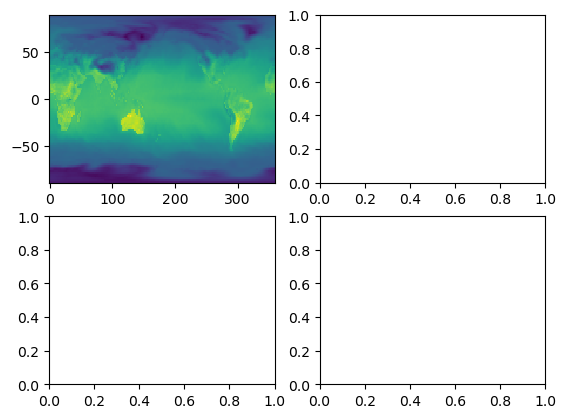

In [4]:
""" Generate a multipanel plot of seasonal max temperature, but only fill in the top left panel. """
import matplotlib.pyplot as plt

# generate a 2x2 panel figure
fig, axs2d = plt.subplots(2,2)

# create a vector of plots (first index is the top left)
axs = axs2d.ravel()

# set the panel
ax = axs[0]
# set the season
season = 'DJF'

# select the data for this season
temp_this_season = max_temp_xr.sel(season = season)

# plot temperature using pcolormesh (each value in the array is assigned a color)
ax.pcolormesh(lon, lat, temp_this_season)

plt.show()

## A sidenote about `zip`

If we want to loop over two things that have the same length, we can use the `zip()` function to loop over corresponding pairs of items in each list.

Say we have `list_1 = [0,1,2,3]` and `list_2 = ['i', 'j', 'k', 'l']`.  Then we can iterate over both using zip, e.g.,:

```
for x1, x2 in zip(list_1, list_2):
    print(x1,x2)
```

Try it below!

In [5]:
""" Test the `zip` function """
list_1 = [0,1,2,3]
list_2 = ['i', 'j', 'k', 'l']

for x1, x2 in zip(list_1, list_2):
    print(x1,x2)

0 i
1 j
2 k
3 l


We can use this to loop over the four seasons in `season` and the four plot panels in `axs`.

## Looping over panels

Use the code above and incorporate a for-loop with `zip` to plot all four seasons.

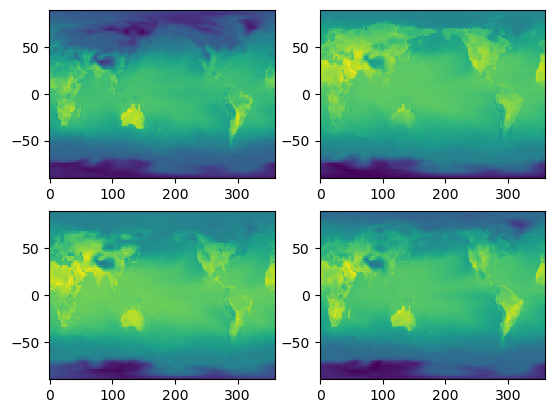

In [6]:
""" Plot data for each season using a for loop and zip"""

# generate a 2x2 panel figure
fig, axs2d = plt.subplots(2,2)

# create a vector of plots (first index is the top left)
axs = axs2d.ravel()

# set the panel
#ax = axs[0]
# set the season
#season = 'DJF'

for ax, season in zip(axs, seasons):
    # select the data for this season
    temp_this_season = max_temp_xr.sel(season = season)

    # plot temperature using pcolormesh (each value in the array is assigned a color)
    ax.pcolormesh(lon, lat, temp_this_season)

plt.show()

Great, now we have a four-panel plot.  But there are some things that I don't like about it:

1. It lacks a colorbar
2. There are no axis labels
3. I don't like the aspect ratio
4. The fonts look ugly to me
5. There's no need to repeat tick labels for each panel
6. There are no panel labels (e.g., panel '(a)')
7. This colormap is way over-used and probably isn't intuitive for temperature
8. It isn't obvious what season each panel corresponds to

We'll walk through these in action below.

In [7]:
""" Force dask to compute the max temperature for each season (saves time when repeating plots)"""

# force computation of the max temperature
max_temp_xr.load()

<xarray.DataArray 'air' (season: 4, lat: 94, lon: 192)>
array([[[268.97998, 269.01   , 269.03   , ..., 268.88998, 268.91998,
         268.96   ],
        [271.03   , 271.24   , 271.41   , ..., 270.53998, 270.50998,
         270.78998],
        [273.93   , 274.     , 274.03   , ..., 273.26   , 273.6    ,
         273.81   ],
        ...,
        [259.98   , 259.79   , 259.62   , ..., 260.59   , 260.37   ,
         260.16998],
        [259.29   , 259.19   , 259.09   , ..., 259.6    , 259.5    ,
         259.4    ],
        [257.61   , 257.54   , 257.47   , ..., 257.82   , 257.75   ,
         257.68   ]],

       [[274.94   , 274.96   , 274.97   , ..., 274.88998, 274.9    ,
         274.91998],
        [274.87   , 274.86   , 274.84   , ..., 274.88998, 274.88   ,
         274.88   ],
        [275.08   , 275.06   , 275.08   , ..., 275.09998, 275.09   ,
         275.06   ],
...
        [255.26999, 254.98   , 254.68   , ..., 256.13   , 255.84999,
         255.56   ],
        [252.84   , 252.65   , 252.45   , ..., 253.39   , 253.20999,
         253.03   ],
        [248.85   , 248.79   , 248.73   , ..., 248.93   , 248.95   ,
         248.9    ]],

       [[273.63   , 273.48   , 273.49   , ..., 273.78   , 273.78   ,
         273.71   ],
        [273.81   , 273.8    , 273.8    , ..., 273.82   , 273.81   ,
         273.81   ],
        [274.07   , 274.06   , 274.06   , ..., 274.11002, 274.09   ,
         274.08   ],
        ...,
        [255.95999, 255.84   , 255.73   , ..., 257.22   , 256.8    ,
         256.37   ],
        [255.82999, 255.79999, 255.76999, ..., 256.37   , 256.08002,
         255.87   ],
        [253.54999, 253.51   , 253.54999, ..., 253.88998, 253.76999,
         253.65999]]], dtype=float32)
Coordinates:
    level    float32 2.0
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/13)
    long_name:      6-Hourly Forecast of Air temperature at 2 m
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    ...             ...
    level_desc:     2 m
    statistic:      Mean
    parent_stat:    Individual Obs
    standard_name:  air_temperature
    valid_range:    [120. 430.]
    actual_range:   [182.33 327.4 ]

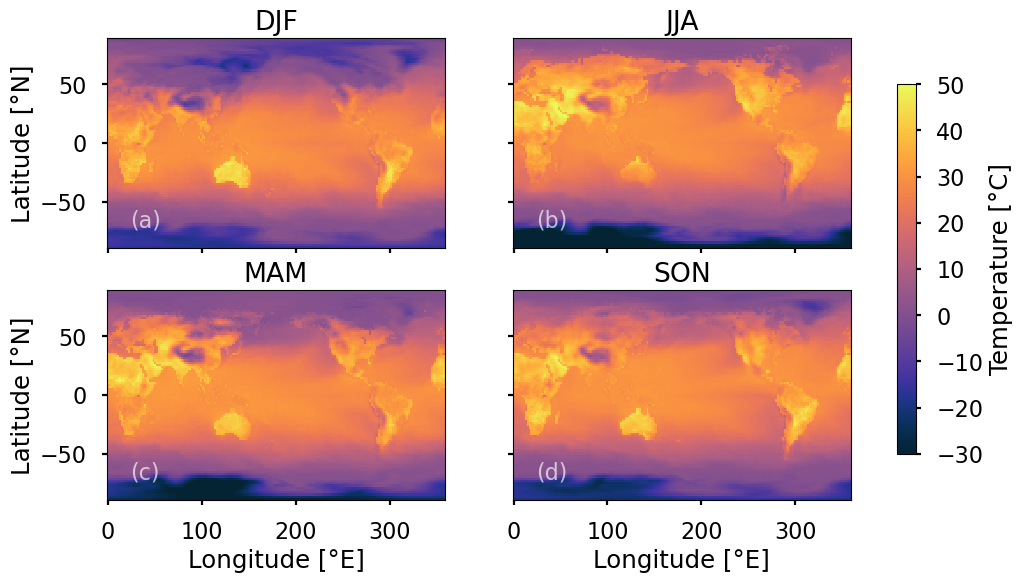

In [8]:
""" Make the plot look nice. """

import cmocean # for better colormaps

# set the style
plt.style.use('seaborn-v0_8-poster')

# set the colormap
cmap = cmocean.cm.thermal


# generate a 2x2 panel figure with a better aspect ratio
fig, axs2d = plt.subplots(
    2,2,
    figsize = (12, 6),
    sharex = True,
    sharey = True
    )

# create a vector of plots (first index is the top left)
axs = axs2d.ravel()

# set panel labels
labels = ['(a)', '(b)', '(c)', '(d)']

for ax, season, label in zip(axs, seasons, labels):
    # select the data for this season and convert to C
    temp_this_season = max_temp_xr.sel(season = season) - 273.15


    # plot temperature using pcolormesh (each value in the array is assigned a color)
    cplt = ax.pcolormesh(
        lon,
        lat,
        temp_this_season,
        cmap = cmap,
        vmin = -30,
        vmax = 50,
        )

    # set the title to the season
    ax.set_title(str(season.values))

    # add a panel label in the lower left of each panel
    ax.text(0.07, 0.1, label, transform = ax.transAxes, fontsize = 16, color = '#FFFFFFAA' )


# add a common colorbar
fig.colorbar(cplt, ax = axs, shrink = 0.8, label = "Temperature [°C]")

# set y-axis labels
axs[0].set_ylabel("Latitude [°N]")
axs[2].set_ylabel("Latitude [°N]")
# set x-axis labels
axs[2].set_xlabel("Longitude [°E]")
axs[3].set_xlabel("Longitude [°E]")

# save the figure to a png file (change the extension to save to other formats)
plt.savefig("seasonal_max_temp.png", dpi = 300)

plt.show()

**Caption**: Maximum 2-meter air temperature in each season of the year 2021.